In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [2]:
import math
import pandas as pd
import numpy as np 

import torch

from nets.segmentation import *
from loaders.tt_dataset import TTDataModuleSeg, TrainTransformsSeg, EvalTransformsSeg

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from evaluation import plot_confusion_matrix

from tqdm import tqdm

2025-09-03 12:59:02.922346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756918742.935669  877813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756918742.939806  877813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756918742.951425  877813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756918742.951438  877813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756918742.951440  877813 computation_placer.cc:177] computation placer alr

In [3]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

In [4]:
batch_size=2
num_workers=4
img_column='img'
seg_column='seg'
class_column='class'
mount_point='/CMF/data/lumargot/trachoma/PoPP_Data/mtss'

In [5]:
train_transform = TrainTransformsSeg()
eval_transform = EvalTransformsSeg()

ttdata = TTDataModuleSeg(df_train, df_val, df_test, batch_size=1, num_workers=num_workers, img_column=img_column, 
                          seg_column=seg_column, class_column=class_column, mount_point=mount_point, train_transform=train_transform, valid_transform=eval_transform, test_transform=eval_transform)


In [6]:
ttdata.setup()
ds = ttdata.test_ds
dl = ttdata.test_dataloader()

In [18]:
segmentation_mask = ds[0]['seg'][0]

In [32]:
mask = segmentation_mask.cpu().numpy()

y_coords, x_coords = np.where(mask > 0)

min_y, max_y = np.min(y_coords), np.max(y_coords)
min_x, max_x = np.min(x_coords), np.max(x_coords)

eyelid_width = max_x - min_x + 1

# Height measurements along the width of the eyelid
heights = []
x_positions = np.linspace(min_x, max_x, num=min(400, eyelid_width)).astype(int)

# print(max_x, max_y, eyelid_width, x_positions)
for x in x_positions:
    y_at_x = y_coords[x_coords == x]
    if len(y_at_x) > 0:
        height_at_x = np.max(y_at_x) - np.min(y_at_x) + 1
        heights.append(height_at_x)
    else:
        heights.append(0)

# heights = np.array(heights)
# valid_heights = heights[heights > 0]
# print(heights.shape)


In [34]:
heights

[1,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 6,
 6,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 6,
 7,
 8,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 12,
 13,
 14,
 14,
 14,
 15,
 16,
 16,
 16,
 17,
 17,
 18,
 18,
 18,
 19,
 19,
 20,
 20,
 21,
 21,
 22,
 23,
 23,
 23,
 24,
 25,
 25,
 25,
 25,
 24,
 25,
 24,
 25,
 24,
 24,
 25,
 26,
 26,
 27,
 27,
 27,
 27,
 28,
 27,
 27,
 28,
 27,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 26,
 27,
 27,
 26,
 26,
 25,
 26,
 27,
 27,
 28,
 28,
 28,
 28,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 30,
 30,
 29,
 29,
 28,
 29,
 29,
 28,
 28,
 27,
 27,
 26,
 26,
 25,
 26,
 25,
 25,
 26,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 26,
 25,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 23,
 23,
 24,
 24,
 25,
 25,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,


In [ ]:
# ckpt = '/CMF/data/lumargot/trachoma/efficientNet/epoch=19-val_loss=0.92.ckpt'
# model = EyelidClassifier.load_from_checkpoint( ckpt, num_classes=3, lr=1e-3)



ckpt = '/CMF/data/lumargot/trachoma/HybridCat/epoch=65-val_loss=0.97.ckpt'
model = HybridEyelidClassifier.load_from_checkpoint( ckpt, num_classes=3, lr=1e-3)


/tools/anaconda3/envs/flyby/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
The parameter 'pretrained' is deprecated sinc

In [3]:
import requests
from transformers import TorchAoConfig, AutoImageProcessor, AutoModelForImageClassification
from torchao.quantization import Int4WeightOnlyConfig
from PIL import Image

In [ ]:
# ! pip install transformers==4.31.0

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-giant-imagenet1k-1-layer')


In [ ]:
from transformers import AutoImageProcessor, AutoModel, Dinov2ForImageClassification

In [33]:
model.classifier.out_features = 3

In [34]:
model

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [39]:
model.train()

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [40]:
# processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small-imagenet1k-1-layer')
# model = AutoModelForImageClassification.from_pretrained('facebook/dinov2-small-imagenet1k-1-layer')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()


In [ ]:
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: tabby, tabby cat


In [12]:
probs, preds, gt = [], [], []
for idx, batch in enumerate(tqdm(dl)):
  img, seg = batch['img'], batch['seg']
  x = torch.cat([img, seg], dim=1)
  out = model(x.cuda(), seg.cuda()).cpu().detach()
  # out = model(x.cuda()).cpu().detach()

  preds.append(torch.argmax(out))
  gt.append(batch['class'])
  probs.append(out)

100%|██████████| 388/388 [00:39<00:00,  9.86it/s]


In [13]:
print(torch.stack(gt)[:,0])
print(torch.stack(preds))

tensor([0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 1,
        1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0,
        2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1, 2, 0, 0, 1, 0, 2, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 2, 1, 1,
        2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1,
        2, 0, 0, 2, 0, 1, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0,
        1, 1, 0, 0, 1, 2, 1, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 0,
        2, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0,
        2, 0, 2, 1, 0, 1, 0, 0, 0, 1, 2,

In [14]:
df_pred = pd.DataFrame(data={'gt':torch.stack(gt)[:,0].cpu().detach(), 'pred': torch.stack(preds).cpu().detach()})
df_pred.to_csv('efficientNetB0-concat.csv')

              precision    recall  f1-score   support

           0       0.56      0.43      0.49       191
           1       0.31      0.36      0.33       120
           2       0.14      0.18      0.16        77

    accuracy                           0.36       388
   macro avg       0.34      0.32      0.33       388
weighted avg       0.40      0.36      0.38       388

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.3249021629911682


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


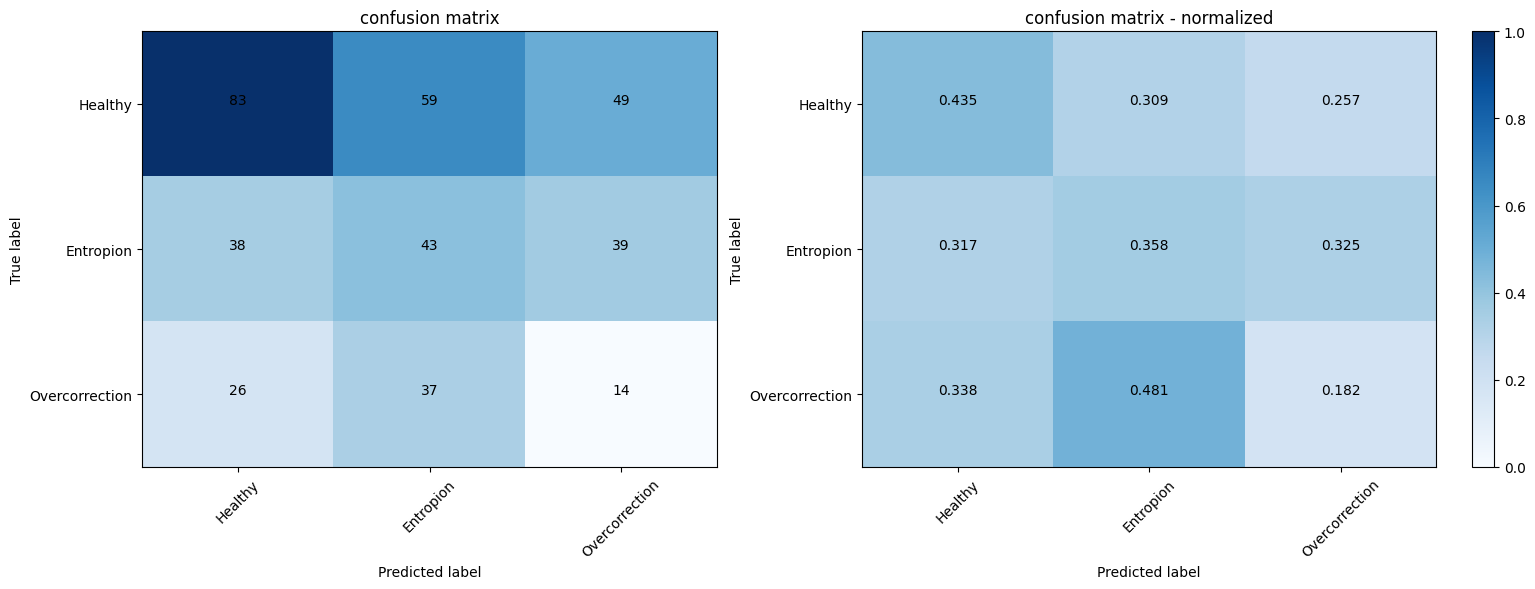

In [15]:

print(classification_report(df_pred['gt'], df_pred['pred']))
report = classification_report(df_pred['gt'], df_pred['pred'], output_dict=True)
df_report = pd.DataFrame(report).transpose()

class_names = ['Healthy', 'Entropion', 'Overcorrection']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_pred['gt'], df_pred['pred'])
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
